### Time Series Decomposition
##### Decomposition is basically applied in time series analysis, it can also be used as a tool to inform forecasting models on a problem

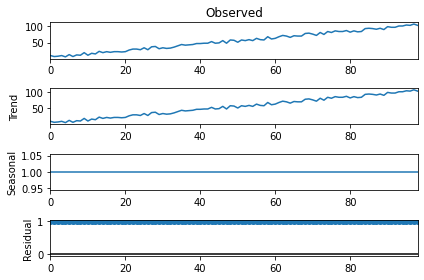

In [10]:
import numpy as np
import pandas as pd
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = [i+randrange(10) for i in range(1,100)]
result = seasonal_decompose(series, model='multiplicative', period=1)
result.plot()
pyplot.show()

### FOrecasting fewer outputs with Enc-Dec LSTM

The shape of the raw_data before scaling is (11940, 8)
Epoch 1/50
27/27 - 4s - loss: 0.3016 - 4s/epoch - 143ms/step
Epoch 2/50
27/27 - 2s - loss: 0.1302 - 2s/epoch - 56ms/step
Epoch 3/50
27/27 - 2s - loss: 0.0817 - 2s/epoch - 56ms/step
Epoch 4/50
27/27 - 2s - loss: 0.0754 - 2s/epoch - 56ms/step
Epoch 5/50
27/27 - 2s - loss: 0.0734 - 2s/epoch - 56ms/step
Epoch 6/50
27/27 - 2s - loss: 0.0718 - 2s/epoch - 57ms/step
Epoch 7/50
27/27 - 2s - loss: 0.0703 - 2s/epoch - 57ms/step
Epoch 8/50
27/27 - 2s - loss: 0.0694 - 2s/epoch - 56ms/step
Epoch 9/50
27/27 - 2s - loss: 0.0688 - 2s/epoch - 56ms/step
Epoch 10/50
27/27 - 2s - loss: 0.0683 - 2s/epoch - 56ms/step
Epoch 11/50
27/27 - 2s - loss: 0.0679 - 2s/epoch - 66ms/step
Epoch 12/50
27/27 - 2s - loss: 0.0676 - 2s/epoch - 57ms/step
Epoch 13/50
27/27 - 2s - loss: 0.0672 - 2s/epoch - 57ms/step
Epoch 14/50
27/27 - 2s - loss: 0.0667 - 2s/epoch - 57ms/step
Epoch 15/50
27/27 - 2s - loss: 0.0667 - 2s/epoch - 57ms/step
Epoch 16/50
27/27 - 2s - loss: 0.0666 

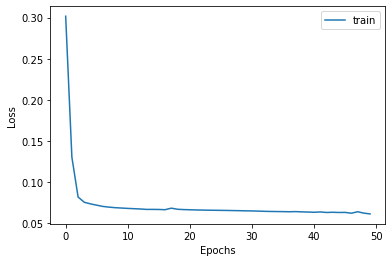

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 50)                11800     
                                                                 
 repeat_vector_13 (RepeatVec  (None, 100, 50)          0         
 tor)                                                            
                                                                 
 lstm_29 (LSTM)              (None, 100, 50)           20200     
                                                                 
 time_distributed_15 (TimeDi  (None, 100, 50)          2550      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 100, 8)           408       
 stributed)                                                      
                                                     

In [42]:
# multivariate output stacked lstm example
import pandas as pd
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, RepeatVector, TimeDistributed
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence

# Read the data
data = read_csv('waterTank.csv', header=0, index_col=0)
# data = read_csv('outputs.csv', header=0, index_col=0)
# data = read_csv('trig.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 1000
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
n_steps_in, n_steps_out = 50, 100
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(50, activation='relu', return_sequences=True))
# model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(n_features)))
# model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=50, verbose=2, shuffle=False)

# demonstrate Direct prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps_in,:]
print(f'Initial shape of x_input {x_inp.shape}')
x_input = x_inp.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(f'The shape of yhat after prediction is {yhat.shape}')
yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.summary()

In [43]:
len(inv_yhat.T)

8

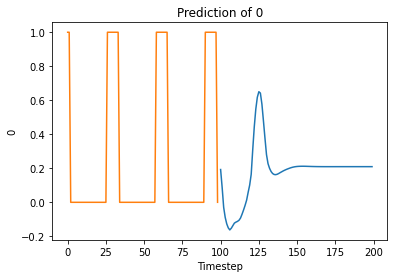

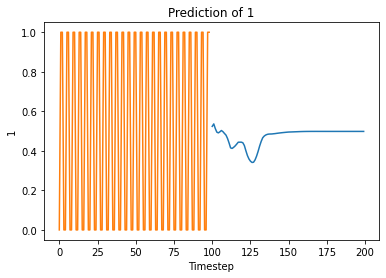

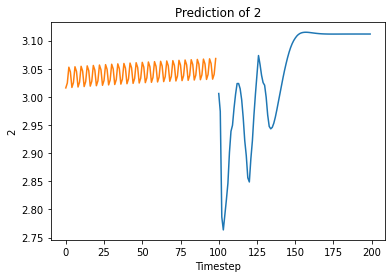

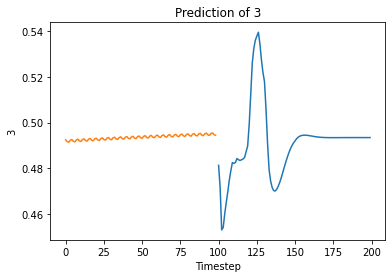

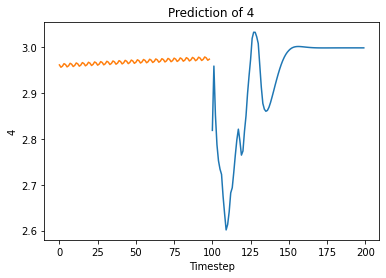

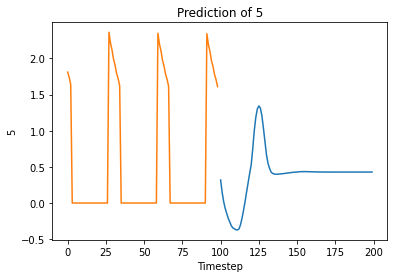

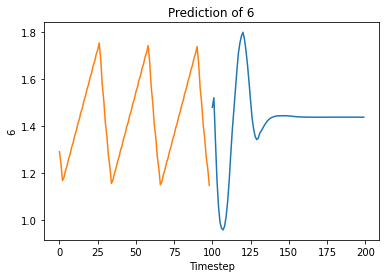

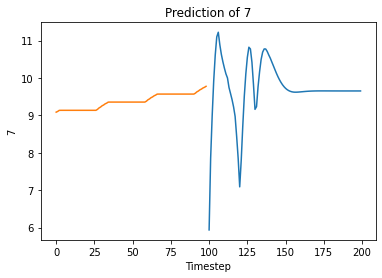

In [44]:
attr = len(inv_yhat.T)
for i in range(attr):
    title = "Prediction of "+str(i)
    actual = raw_data[951:1050,i]
    pred = inv_yhat.T
    pred_df = pd.DataFrame(inv_yhat)
    index = pd.Index(list(range(100,200)))
    pred_df = pred_df.set_index(index)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(i)
#     plt.plot(pred[i], label="predicted")
#     plt.plot(actual, label="actual")
    plt.plot(pred_df[i])
    plt.plot(actual)
    plt.show()